In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
def generate(sineCoeffArray, sinePeriodsArray, timeSteps, tStart = 0):

    if (len(sineCoeffArray) != len(sinePeriodsArray)):
        raise Exception('sineCoeffArray and sinePeriodsArray must be of the same length.')

    outputArray = np.zeros(timeSteps)
    T = float(timeSteps)
    for i in range(tStart, timeSteps):
        value = 0.0
        for j in range(0, len(sineCoeffArray)):
            value += (sineCoeffArray[j] * np.sin(i * sinePeriodsArray[j] * 2.0 * np.pi / T ))
        
        outputArray[i] = value

    return outputArray


def matrixFromSVD(s, U, V,k):
    Uk = U[:,:k]
    Vk = V[:k,:]
    sk = s[:k]
    
    return  np.dot(Uk, np.dot(np.diag(sk), Vk))


def pInverseMatrixFromSVD(sk, Uk, Vk, soft_threshold=0,probability=1.0):
    s = np.array(sk)
    s = s - soft_threshold

    for i in range(0, len(s)):
        if (s[i] > 0.0):
            s[i] = 1.0/s[i]

    p = 1.0/probability
    return np.dot(Uk, np.dot(np.diag(s), Vk))

def randomlyHideValues(array, pObservation):

    count = 0
    for i in range(0, len(array)):
        if (np.random.uniform(0, 1) > pObservation):
            array[i] = np.nan
            count +=1 
    return array

def normalize(array, max, min):
    """

    :param array:
    :param max:
    :param min:
    :param pos: if true, normalize between 0 and 1
    :return:
    """

#     max = np.max(array)
#     min = np.min(array)
    
   
    diff = 0.5 * (min + max)
    div = 0.5 * (max - min)
    array = (array - diff) / div
    return array


In [3]:
# def gen_tensor(n,m,T,k):# j /in [n]

#     prediction_slack = 0
#     sine_coeff_u = np.random.random([m,k])
#     sine_perisods_u = 20*np.random.random([m,k]) + 1

#     sine_coeff_v = np.random.random([n,k])
#     sine_perisods_v = 20*np.random.random([n,k]) + 1
#     tensor = np.zeros([n,m,T+prediction_slack])
#     for i in range(m):
#         for j in range(n):
#             for q in range(k):
#                 tensor[j,i,:] += generate([sine_coeff_u[i,q]], [sine_perisods_u[i,q]], T+prediction_slack )* \
#                         generate([sine_coeff_v[j,q]], [sine_perisods_v[j,q]], T+prediction_slack)
#     return tensor

def gen_tensor_time_har(n,m,T,k, num_har = 1):# j /in [n]

    prediction_slack = 10000
    sine_coeff = 2*np.random.random([k,num_har]) -1 
    sine_perisods = 50*np.random.random([k,num_har]) + 1
    tensor = np.zeros([n,m,T+prediction_slack])
    u = np.random.normal(0,3,[n,k])
    v = np.random.normal(0,3,[k,m])
    wt = np.zeros([T+prediction_slack,k])
    for q in range(k):
        wt[:,q] = generate(sine_coeff[q,:], sine_perisods[q,:], T+prediction_slack )
    for i in range(m):
        for j in range(n):
            for q in range(k):
                tensor[j,i,:] += u[j,q]*v[q,i]*wt[:,q]
    return tensor

# def gen_tensor_time_poly(n,m,T,k, degrees = 1):# j /in [n]

#     prediction_slack = 0
#     poly_coeff = np.random.random([k,degrees])/1000
#     tensor = np.zeros([n,m,T+prediction_slack])
#     u = np.random.normal(0,1,[n,k])
#     v = np.random.normal(0,1,[k,m])
#     wt = np.zeros([T,k])
#     for q in range(k):
#             wt[:,q] = np.sum([poly_coeff[q,i-1] * np.arange(T)**i for i in range(1,degrees+1)], axis = 0)

#     for i in range(m):
#         for j in range(n):
#             for q in range(k):
#                 tensor[j,i,:] += u[j,q]*v[q,i]*wt[:,q]
#     return tensor

# def gen_tensor_time(n,m,T,k):# j /in [n]

#     prediction_slack = 0
#     sine_coeff = np.random.random([1])
#     sine_perisods = 20*np.random.random([1]) + 1
#     tensor = np.zeros([n,m,T+prediction_slack])
#     u = np.random.normal(0,1,[n,k])
#     v = np.random.normal(0,1,[k,m])
#     w_t = generate([sine_coeff[0]], [sine_perisods[0]], T+prediction_slack )
#     for t in range(T):
#                 tensor[:,:,t] += np.dot(u,v)*w_t[t]
#     return tensor

def flatten_tensor(tensor, L):
    n,m,T = tensor.shape
    matrix = tensor.T.reshape([T,m*n],order = 'c')
    N = T//L
    page_matrix__ = matrix[:L*N,:].reshape([L, m*n*N], order = 'F')
    return page_matrix__

# Comparisons experiments
### Keep T fixed , change p and noise
### Keep T fixed, p noise, AND VARY MATRIX
### keep everything fixed, vary k



In [4]:
def multi_vs_single(generate_tensor, n, m,T, k, L, p, std = 1.0, select_time_series = None, num_ser = 20, tensor = None):
    # Generate Tensor
    num_ser = min(num_ser, n*m)
    N = T//L
    
    if tensor is None: tensor = generate_tensor(n,m,T,k, num_har = 2)
    else: assert tensor.shape == (n,m,T+10000)
    
    if select_time_series is None:
        select_time_series =  np.random.choice(n*m, num_ser, replace=False)
    assert len(select_time_series) <= m*N
    
    means_test = tensor[:,:,T:]
    tensor_test = tensor[:,:,T:] + np.random.normal(0,std,means_test.shape)
    means = tensor[:,:,:T]
    
    obs = means + np.random.normal(0,std,means.shape)
    shape = obs.shape
    
    array_obs = obs.flatten('C')
    array_obs = randomlyHideValues(array_obs, p)
    obs = array_obs.reshape(shape)
    
    # Multiple time series
    page_matrix = flatten_tensor(obs, L)
    page_matrix = np.array(pd.DataFrame(page_matrix).fillna(value = 0).values)
    
    page_matrix_means = flatten_tensor(means, L)
    
    # denoise
    u,s,v = np.linalg.svd(page_matrix)
    S = np.cumsum(s)
    S = S/S[-1]
    r = min(k * 2, 10)
    M_hat = matrixFromSVD(s,u,v,r)
    
    # estimate coefficients
    u,s,v = np.linalg.svd(page_matrix[:-1,:])
    Uk = u[:,:r]
    Vk = v[:r,:]
    sk = s[:r]
    weights2 = np.dot(pInverseMatrixFromSVD(sk, Uk, Vk), page_matrix[-1,:].T)
    
    # Imputation error
    imp_rmse_mult = np.zeros(select_time_series.shape)
    imp_r2_mult = np.zeros(select_time_series.shape)
    imp_rmse_single = np.zeros(select_time_series.shape)
    imp_r2_single = np.zeros(select_time_series.shape)
    
    
    # Forecast error
    fore_rmse_mult = np.zeros(select_time_series.shape)
    fore_r2_mult = np.zeros(select_time_series.shape)
    fore_rmse_single = np.zeros(select_time_series.shape)
    fore_r2_single = np.zeros(select_time_series.shape)
    
    for j,i in enumerate(select_time_series):
        

        # single time series:
        page_matrix_single = page_matrix[:,i*N:(i+1)*N] 
        page_matrix_means_single = page_matrix_means[:,i*N:(i+1)*N]
        u,s,v = np.linalg.svd(page_matrix_single)
        S = np.cumsum(s)
        S = S/S[-1]
        r2 = min(k*2,10)
        M_hat_single = matrixFromSVD(s,u,v,r2)
        
        u,s,v = np.linalg.svd(page_matrix_single[:-1,:])
        Uk = u[:,:r2]
        Vk = v[:r2,:]
        sk = s[:r2]
        weights1 = np.dot(pInverseMatrixFromSVD(sk, Uk, Vk), page_matrix_single[-1,:].T)
        
        est_single = M_hat_single.flatten('F')
        estimate1 = list(est_single[-L+1:])
        means_single = page_matrix_means_single.flatten('F')
        max_, min_ = np.max(means_single), np.min(means_single)
        imp_rmse_single[j] = np.sqrt(np.mean(np.square(normalize(est_single, max_, min_) - normalize(means_single, max_, min_))))
        imp_r2_single[j] =  r2_score(means_single,M_hat_single.flatten('F')) 
        # multiple ts
        M_hat_ts = M_hat[:,i*N:(i+1)*N]
        est_multi = M_hat_ts.flatten('F')
        imp_rmse_mult[j] = np.sqrt(np.mean(np.square(normalize(est_multi, max_, min_) - normalize(means_single, max_, min_))))
        imp_r2_mult[j] =  r2_score(means_single,est_multi)
        estimate2 = list(est_multi[-L+1:])
        
        #forecasting
        y = means_test[i%n,i//n,:]
        x = tensor_test[i%n,i//n,:]
        y_h2 = []
        y_h1 = []

        for i in range(len(y)):
            y_h2.append(np.dot(estimate2[-L+1:], weights2))
            y_h1.append(np.dot(estimate1[-L+1:], weights1))
            
            if False and i%10!=0:
                estimate1.append(y_h1[i])
                estimate2.append(y_h2[i])
            else: 
                estimate1.append(y[i])
                estimate2.append(y[i])
        
        fore_r2_single[j] =  r2_score(y,y_h1)
        fore_r2_mult[j] =  r2_score(y,y_h2)
        
        max_, min_ = np.max(y), np.min(y)
        fore_rmse_single[j] =  np.sqrt(np.mean(np.square(normalize(y,max_, min_) - normalize(y_h1, max_, min_))))
        fore_rmse_mult[j] =   np.sqrt(np.mean(np.square(normalize(y,max_, min_) - normalize(y_h2, max_, min_))))
    
    return imp_r2_mult,imp_rmse_mult, imp_r2_single, imp_rmse_single, fore_r2_mult,fore_rmse_mult, fore_r2_single, fore_rmse_single
    






     


    

### Vary p and noise-level

0.1
0.36363636363636365
0.6272727272727272
0.8909090909090908
1.1545454545454545
1.4181818181818182
1.6818181818181817
1.9454545454545453
2.209090909090909
2.4727272727272727
2.7363636363636363
3.0


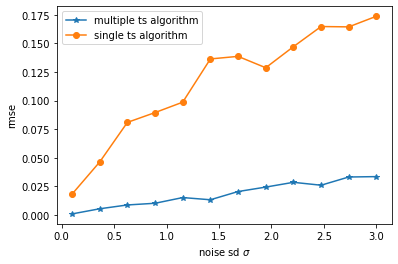

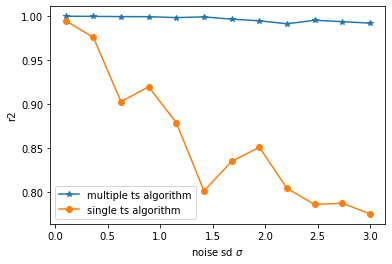

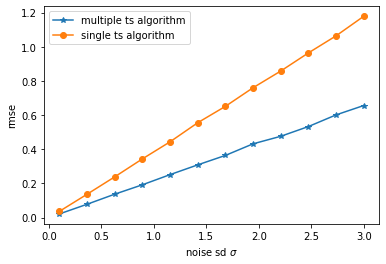

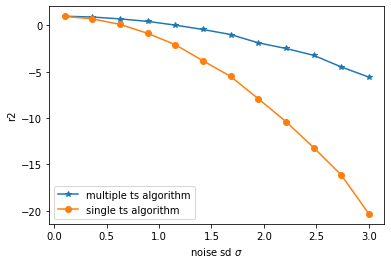

In [5]:
Forecast_rmse_single, Forecast_r2_single,Forecast_rmse_multiple,Forecast_r2_multiple, Imp_rmse_single,Imp_r2_single, Imp_rmse_multiple, Imp_r2_multiple= [],[],[],[],[],[],[],[]
SDs = np.linspace(0.1,3,12)
n = 10
m = 10
tensor = gen_tensor_time_har(n, m,T = 10000, k = 2, num_har = 2)
select_time_series = np.random.choice(n*m, 20, replace=False)
for sd in SDs:
    print(sd)
    
    imp_r2_mult,imp_rmse_mult, imp_r2_single, imp_rmse_single, fore_r2_mult,fore_rmse_mult, fore_r2_single,\
    fore_rmse_single = multi_vs_single(gen_tensor_time_har, 10, 10,select_time_series= select_time_series, T = 10000, k = 2, L =100, p = 1, std = sd, tensor = np.array(tensor))

    Forecast_rmse_single.append(np.mean(fore_rmse_single))
    Forecast_r2_single.append(np.mean(fore_r2_single))
    Forecast_rmse_multiple.append(np.mean(fore_rmse_mult))
    Forecast_r2_multiple.append(np.mean(fore_r2_mult))

    Imp_rmse_single.append(np.mean(imp_rmse_single))
    Imp_r2_single.append(np.mean(imp_r2_single))
    Imp_rmse_multiple.append(np.mean(imp_rmse_mult))
    Imp_r2_multiple.append(np.mean(imp_r2_mult))


plt.figure()
plt.plot(SDs, Forecast_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(SDs, Forecast_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('noise sd $\sigma$')
plt.legend()

plt.figure()
plt.plot(SDs, Forecast_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(SDs, Forecast_r2_single, '-o',label = 'single ts algorithm')

plt.ylabel('r2')
plt.xlabel('noise sd $\sigma$')
plt.legend()


plt.figure()
plt.plot(SDs, Imp_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(SDs, Imp_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('noise sd $\sigma$')
plt.legend()

plt.figure()
plt.plot(SDs, Imp_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(SDs, Imp_r2_single, '-o',label = 'single ts algorithm')
plt.ylabel('r2')
plt.xlabel('noise sd $\sigma$')
plt.legend()


### Vary p

1.0
0.9
0.8
0.7
0.6
0.5
0.4


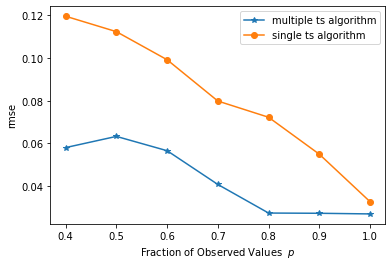

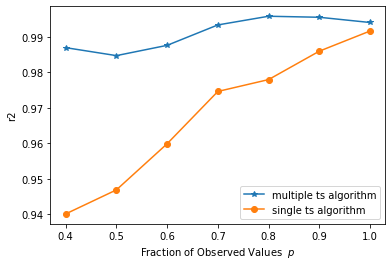

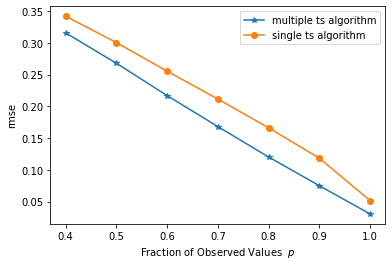

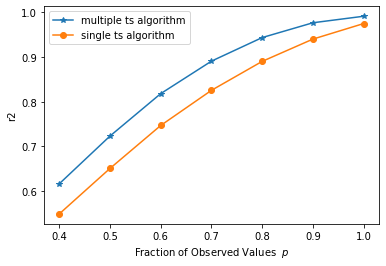

In [5]:
Forecast_rmse_single, Forecast_r2_single,Forecast_rmse_multiple,Forecast_r2_multiple, Imp_rmse_single,Imp_r2_single, Imp_rmse_multiple, Imp_r2_multiple= [],[],[],[],[],[],[],[]
P = [1.0,0.9,0.8,0.7,0.6,0.5,0.4]
n = 10
m = 10
tensor = gen_tensor_time_har(n, m,T = 10000, k = 3, num_har = 2)
select_time_series = np.random.choice(n*m, 20, replace=False)
for p in P:
    print(p)
    imp_r2_mult,imp_rmse_mult, imp_r2_single, imp_rmse_single, fore_r2_mult,fore_rmse_mult, fore_r2_single,\
    fore_rmse_single = multi_vs_single(gen_tensor_time_har, n, m,select_time_series= select_time_series, \
                                       T = 10000, k = 3, L =100, p = p, std = 0.5, tensor = np.array(tensor))

    Forecast_rmse_single.append(np.mean(fore_rmse_single))
    Forecast_r2_single.append(np.mean(fore_r2_single))
    Forecast_rmse_multiple.append(np.mean(fore_rmse_mult))
    Forecast_r2_multiple.append(np.mean(fore_r2_mult))

    Imp_rmse_single.append(np.mean(imp_rmse_single))
    Imp_r2_single.append(np.mean(imp_r2_single))
    Imp_rmse_multiple.append(np.mean(imp_rmse_mult))
    Imp_r2_multiple.append(np.mean(imp_r2_mult))


plt.figure()
plt.plot(P, Forecast_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(P, Forecast_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('Fraction of Observed Values  $p$')
plt.legend()

plt.figure()
plt.plot(P, Forecast_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(P, Forecast_r2_single, '-o',label = 'single ts algorithm')

plt.ylabel('r2')
plt.xlabel('Fraction of Observed Values  $p$')
plt.legend()


plt.figure()
plt.plot(P, Imp_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(P, Imp_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('Fraction of Observed Values  $p$')
plt.legend()

plt.figure()
plt.plot(P, Imp_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(P, Imp_r2_single, '-o',label = 'single ts algorithm')
plt.ylabel('r2')
plt.xlabel('Fraction of Observed Values  $p$')
plt.legend()

### Vary rank

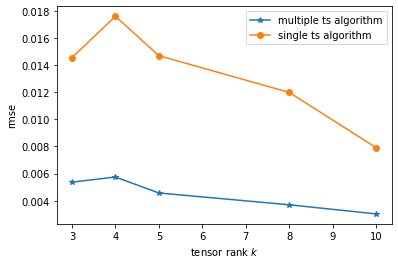

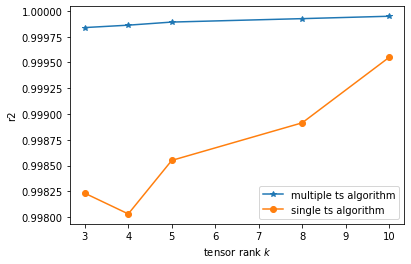

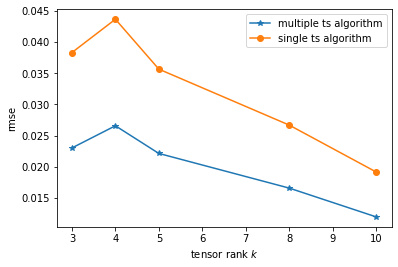

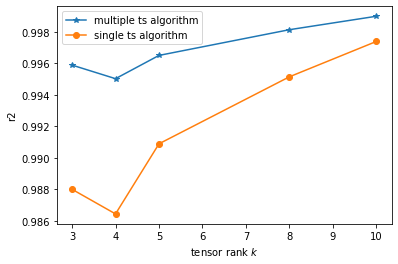

In [6]:
Forecast_rmse_single, Forecast_r2_single,Forecast_rmse_multiple,Forecast_r2_multiple, Imp_rmse_single,Imp_r2_single, Imp_rmse_multiple, Imp_r2_multiple= [],[],[],[],[],[],[],[]
K = [3,4,5,8,10]
p = 1
sd = 1
n = 10
m = 10
for k in K:
    
    imp_r2_mult,imp_rmse_mult, imp_r2_single, imp_rmse_single, fore_r2_mult,fore_rmse_mult, fore_r2_single,\
    fore_rmse_single = multi_vs_single(gen_tensor_time_har, n, m, \
                                       T = 10000, k = k, L =100, p =p, std = sd,num_ser = 100)

    Forecast_rmse_single.append(np.mean(fore_rmse_single))
    Forecast_r2_single.append(np.mean(fore_r2_single))
    Forecast_rmse_multiple.append(np.mean(fore_rmse_mult))
    Forecast_r2_multiple.append(np.mean(fore_r2_mult))

    Imp_rmse_single.append(np.mean(imp_rmse_single))
    Imp_r2_single.append(np.mean(imp_r2_single))
    Imp_rmse_multiple.append(np.mean(imp_rmse_mult))
    Imp_r2_multiple.append(np.mean(imp_r2_mult))


plt.figure()
plt.plot(K, Forecast_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(K, Forecast_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('tensor rank $k$')
plt.legend()

plt.figure()
plt.plot(K, Forecast_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(K, Forecast_r2_single, '-o',label = 'single ts algorithm')

plt.ylabel('r2')
plt.xlabel('tensor rank $k$')
plt.legend()


plt.figure()
plt.plot(K, Imp_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(K, Imp_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('tensor rank $k$')
plt.legend()

plt.figure()
plt.plot(K, Imp_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(K, Imp_r2_single, '-o',label = 'single ts algorithm')
plt.ylabel('r2')
plt.xlabel('tensor rank $k$')
plt.legend()

### Vary no. time series

In [ ]:
Forecast_rmse_single, Forecast_r2_single,Forecast_rmse_multiple,Forecast_r2_multiple, Imp_rmse_single,Imp_r2_single, Imp_rmse_multiple, Imp_r2_multiple= [],[],[],[],[],[],[],[]
N = [2,5,7,10,13,15,20]
p = 1
sd = 1
k = 3
for n in N:
    print(n)
    imp_r2_mult,imp_rmse_mult, imp_r2_single, imp_rmse_single, fore_r2_mult,fore_rmse_mult, fore_r2_single,\
    fore_rmse_single = multi_vs_single(gen_tensor_time_har, n, max(n,10), \
                                       T = 10000, k = k, L =50, p =p, std = sd,num_ser = 20)

    Forecast_rmse_single.append(np.mean(fore_rmse_single))
    Forecast_r2_single.append(np.mean(fore_r2_single))
    Forecast_rmse_multiple.append(np.mean(fore_rmse_mult))
    Forecast_r2_multiple.append(np.mean(fore_r2_mult))

    Imp_rmse_single.append(np.mean(imp_rmse_single))
    Imp_r2_single.append(np.mean(imp_r2_single))
    Imp_rmse_multiple.append(np.mean(imp_rmse_mult))
    Imp_r2_multiple.append(np.mean(imp_r2_mult))

N = np.array(N)

plt.figure()
plt.plot(10*N, Forecast_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Forecast_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('$number of time series$ $n$')
plt.legend()

plt.figure()
plt.plot(10*N, Forecast_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Forecast_r2_single, '-o',label = 'single ts algorithm')

plt.ylabel('r2')
plt.xlabel('$ number of time series$ $n$')
plt.legend()


plt.figure()
plt.plot(10*N, Imp_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Imp_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('$number of time series$ $n$')
plt.legend()

plt.figure()
plt.plot(10*N, Imp_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Imp_r2_single, '-o',label = 'single ts algorithm')
plt.ylabel('r2')
plt.xlabel('$number of time series $ $n$')
plt.legend()

2
5
7
10
13


### Real World Experiment

In [ ]:
N = np.array(N)
plt.figure()
plt.plot(10*N, Forecast_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Forecast_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('$number of time series$ $n$')
plt.legend()

plt.figure()
plt.plot(10*N, Forecast_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Forecast_r2_single, '-o',label = 'single ts algorithm')

plt.ylabel('r2')
plt.xlabel('$ number of time series$ $n$')
plt.legend()


plt.figure()
plt.plot(10*N, Imp_rmse_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Imp_rmse_single, '-o',label = 'single ts algorithm')

plt.ylabel('rmse')
plt.xlabel('$number of time series$ $n$')
plt.legend()

plt.figure()
plt.plot(10*N, Imp_r2_multiple, '-*',label = 'multiple ts algorithm')
plt.plot(10*N, Imp_r2_single, '-o',label = 'single ts algorithm')
plt.ylabel('r2')
plt.xlabel('$number of time series $ $n$')
plt.legend()

## Rank Experiments

In [ ]:
T = 10000
n = 20
m = 20
rank = []
K = list(range(1,15))
effective_rank = []
Harmonics = [1,2,3,4,6]
for j,num_har in enumerate(Harmonics):
    print(j)
    rank.append([])
    for k in K: 
        tensor = gen_tensor_time_har(n,m,T,k,num_har = num_har)
        page_matrixx = flatten_tensor(tensor, 100)
        rank[j].append(np.linalg.matrix_rank(page_matrixx))
print(page_matrixx.shape)

In [ ]:
colors = ['red','blue', 'green','orange','m']
for j,num_har in enumerate(Harmonics):
    plt.plot(K, rank[j], '-*',c = colors[j], label = 'Page Matrix Rank, no. harmonics = %s '%num_har)
    plt.plot(K,np.array(K)*num_har*2, '--',c = colors[j], linewidth = 0.5)
plt.ylim([0,17])
plt.xlabel('tensor rank')
plt.ylabel('page matrix rank')
plt.legend()


In [ ]:
T = 10000
n = 30
m = 30
k = 1
rank = []
K = list(range(1,15))
effective_rank = []
L = [20,50,100,200,500]
for j,l in enumerate(L):
    print(j)
    rank.append([])
    for k in K: 
        tensor = gen_tensor_time_har(n,m,T,k,num_har = 1)
        page_matrixx = flatten_tensor(tensor, l)
        rank[j].append(np.linalg.matrix_rank(page_matrixx))
print(page_matrixx.shape)

In [ ]:

for j,l in enumerate(L):
    plt.plot(K, rank[j], '-*',label = 'Page Matrix Rank, L = %s '%l)
plt.plot(K,np.array(K)*2, '--', linewidth = 0.5)
plt.xlabel('tensor rank')
plt.ylabel('page matrix rank')
plt.legend()

In [ ]:
T = 10000
n = 30
m = 30
k = 1
rank = []
K = list(range(1,15))
effective_rank = []
for k in K:
    tensor = gen_tensor_time_poly(n,m,T,k,degrees = 4)
    page_matrixx = flatten_tensor(tensor, 100)
    rank.append(np.linalg.matrix_rank(page_matrixx))
    print(k, rank[-1])
print(page_matrixx.shape)

In [ ]:
# plt.plot(K, rank, label = 'Real rank')
# plt.plot(K,1*np.array(K),'--')
# plt.xlabel('tensor rank')
# plt.ylabel('page matrix rank')
# plt.legend()
plt.plot(tensor[0,0,:])

In [ ]:
degrees = 2
poly_coeff = np.random.random([degrees,k])/1000
wt = np.zeros([T,k])
for q in range(k):
        wt[:,q] = np.sum([poly_coeff[i-1,q] * np.arange(T)**i for i in range(1,degrees+1)], axis = 0)
  